## import all the tools

In [1]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

^C
ERROR: Operation cancelled by user


In [2]:
# !pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
# import os
# import torch
# from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer, TrainingArguments 
# from peft import LoraConfig, get_peft_model
# from trl import SFTTrainer
# from datasets import load_dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import pandas as pd

# Load the CSV file into a DataFrame
df_prompt = pd.read_csv("/kaggle/input/aibe-mcq-silver-training-dataset/All_India_Bar_Exam-MCQs_Experiment - (315)All-Silver.csv")

# Display the first row
first_row = df_prompt.iloc[0]
print(first_row)


Question       The objectives of the EU Directive on mediatio...
Options        ['a) Reducing backlogs of cases at the courts ...
Answer         d) Ensuring better access to alternative dispu...
Explanation    The main aim of the EU Directive on mediation ...
Name: 0, dtype: object


In [4]:
# Display the first row with some styling
df_prompt.head(1).style.set_table_attributes("border=1").set_caption("First Row of the Dataset")


,Question,Options,Answer,Explanation
0,The objectives of the EU Directive on mediation is:,"['a) Reducing backlogs of cases at the courts in the member states', 'b) Dividing the cases between all the dispute resolution methods', 'c) Economical reasons in times of crisis, thus ensuring that mediators will have a better a proper income.', 'd) Ensuring better access to alternative dispute resolution in cross-border commercial conflicts.']",d) Ensuring better access to alternative dispute resolution in cross-border commercial conflicts.,The main aim of the EU Directive on mediation is to facilitate access to alternative dispute resolution and to promote the amicable settlement of disputes by encouraging the use of mediation.


## prepare data-set with proper prompt

In [1]:
import pandas as pd
import json

# Load the CSV file
df_prompt = pd.read_csv("/kaggle/input/aibe-mcq-silver-training-dataset/All_India_Bar_Exam-MCQs_Experiment - (315)All-Silver.csv")

# Define the prompt template
prompt_template = """<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: {{ question_text }} 
### Options: {{ options_list }} [/INST] 
### Answer: {{ model_answer }} </s>"""

# Create a list of formatted texts
formatted_texts = []
for _, row in df_prompt.iterrows():
    formatted_text = prompt_template.replace("{{ question_text }}", row["Question"])
    formatted_text = formatted_text.replace("{{ options_list }}", row["Options"])
    model_answer = row["Answer"]
    if pd.notnull(row["Explanation"]):
        model_answer += " " + row["Explanation"]
    formatted_text = formatted_text.replace("{{ model_answer }}", model_answer)
    formatted_texts.append(formatted_text)

# Convert the list of formatted texts to JSONL format
jsonl_data = [{"text": text} for text in formatted_texts]
jsonl_output_path_prompt = "/kaggle/working/full_silver_data.jsonl"
with open(jsonl_output_path_prompt, 'w') as jsonl_file:
    for item in jsonl_data:
        jsonl_file.write(json.dumps(item) + '\n')

In [2]:
import json

# File path
file_path = "/kaggle/working/full_silver_data.jsonl"

# Read the first line (JSON object) from the file
with open(file_path, 'r') as file:
    first_line = file.readline()
    data = json.loads(first_line)

# Pretty-print the JSON data
formatted_data = json.dumps(data, indent=4)
print(formatted_data)


{
    "text": "<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: The objectives of the EU Directive on mediation is: \n### Options: ['a) Reducing backlogs of cases at the courts in the member states', 'b) Dividing the cases between all the dispute resolution methods', 'c) Economical reasons in times of crisis, thus ensuring that mediators will have a better a proper income.', 'd) Ensuring better access to alternative dispute resolution in cross-border commercial conflicts.'] [/INST] \n### Answer: d) Ensuring better access to alternative dispute r

## Train and validation split

In [10]:
import random

# Load the JSONL file into a list
with open("/kaggle/working/full_silver_data.jsonl", 'r') as f:
    data = [json.loads(line) for line in f]

# Shuffle the list
random.shuffle(data)

# Define the split ratio
train_ratio = 0.8
split_index = int(train_ratio * len(data))

# Split the data into training and validation sets
train_data = data[:split_index]
val_data = data[split_index:]

# Save the training and validation sets into separate JSONL files
with open("/kaggle/working/train.jsonl", 'w') as train_file:
    for item in train_data:
        train_file.write(json.dumps(item) + '\n')

with open("/kaggle/working/val.jsonl", 'w') as val_file:
    for item in val_data:
        val_file.write(json.dumps(item) + '\n')


In [11]:
train_dataset = load_dataset('json', data_files='/kaggle/working/train.jsonl', split='train')  
eval_dataset = load_dataset('json', data_files='/kaggle/working/val.jsonl', split='train')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-38387fb0403fe5d7/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-3499a930d6d743f8/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


In [12]:
train_dataset

Dataset({
    features: ['text'],
    num_rows: 252
})

In [13]:
eval_dataset[0]

{'text': "<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: The definition of Contract is defined under \n### Options: ['a) Section 2(a) of the Indian Contract Act.', 'b) Section 2(h) of the Indian Contract Act.', 'c) Section 2(d) of the Indian Contract Act.', 'd) Section 2(g) of the Indian Contract Act.'] [/INST] \n### Answer: b) Section 2(h) of the Indian Contract Act. As per the Indian Contract Act, 1872, the definition of a contract is given under Section 2(h) which states, an agreement enforceable by law is a contract. </s>"}

## count the token size of training and val set**

In [17]:
file_path = "/kaggle/working/train.jsonl"

with open(file_path, 'r') as file:
    
    total_line = file.readlines()
    print(len(total_line))
    
    length_token = []
    
    for _ in total_line:
        token = list(tokenizer.tokenize(_))
        length_token.append(len(token))
        
    avg = sum(length_token)/len(length_token)
    print(min(length_token), max(length_token), avg)

252
195 831 270.8095238095238


In [18]:
file_path = "/kaggle/working/val.jsonl"

with open(file_path, 'r') as file:
    
    total_line = file.readlines()
    print(len(total_line))
    
    length_token = []
    
    for _ in total_line:
        token = list(tokenizer.tokenize(_))
        length_token.append(len(token))
        
    avg = sum(length_token)/len(length_token)
    print(min(length_token), max(length_token), avg)

63
216 415 259.63492063492066


# load the model

this is from second trial trial

In [15]:
model_name = "meta-llama/Llama-2-7b-hf" 
dataset_name = "/kaggle/working/train.jsonl"
new_model = "Llama2-SFT-AIBE-silver-v1"
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False
output_dir = "Llama2-SFT-AIBE-silver-v1"
num_train_epochs = 1
fp16 = False
bf16 = False
per_device_train_batch_size = 4
per_device_eval_batch_size = 4
gradient_accumulation_steps = 1
gradient_checkpointing = True
max_grad_norm = 0.3
learning_rate = 2e-4
weight_decay = 0.001
optim = "paged_adamw_32bit"
lr_scheduler_type = "constant"
max_steps = -1
warmup_ratio = 0.03
group_by_length = True
save_steps = 25
logging_steps = 5
max_seq_length = 1024
packing = False
device_map = {"": 0}

In [16]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="all",
    evaluation_strategy="steps",
    eval_steps=5  # Evaluate every 20 steps
)
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [19]:
trainer.train() # second time

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
5,1.993500,1.936263
10,1.831200,1.533473
15,1.479100,1.085068
20,1.006300,0.714221
25,0.656200,0.536545
30,0.559100,0.509200
35,0.775200,0.501732
40,0.586500,0.493852
45,0.488400,0.486390
50,0.663600,0.481465


TrainOutput(global_step=63, training_loss=0.9009787392994714, metrics={'train_runtime': 914.7656, 'train_samples_per_second': 0.275, 'train_steps_per_second': 0.069, 'total_flos': 1392628120289280.0, 'train_loss': 0.9009787392994714, 'epoch': 1.0})

In [9]:
trainer.train() #first time

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
5,2.103900,2.033591
10,1.923800,1.654995
15,1.532900,1.137936
20,0.962900,0.690025
25,0.546800,0.545528
30,0.472200,0.514609
35,0.590500,0.503583
40,0.436900,0.495863
45,0.364100,0.488525
50,0.519100,0.485677


TrainOutput(global_step=63, training_loss=0.8356008662117852, metrics={'train_runtime': 1180.3991, 'train_samples_per_second': 0.213, 'train_steps_per_second': 0.053, 'total_flos': 1608807256719360.0, 'train_loss': 0.8356008662117852, 'epoch': 1.0})

In [13]:
output_dir = "Llama2-SFT-AIBE-silver-v1"

In [15]:
%reload_ext tensorboard
%tensorboard --load_fast=false --logdir Llama2-SFT-AIBE-silver-v1/runs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

# let us test the model

In [72]:
import pandas as pd
test_df = pd.read_csv("/kaggle/input/aibe-mcq-testing-dataset/AIBE-XVII.csv")

In [32]:
text = test_df[2:3].to_string()
text

"                                                            Question                                                                                                                Option\n2  3. Who is known as Father of Public Interest Litigation in India?  ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati']"

## first time

In [26]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
prompt = f"<s> [INST]\n<<SYS>>\nYou are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. \n\nAlways ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.\n<</SYS>>\n### Question: The Section 12 of Hindu Maintenance and Adoption Act, 1956 deals with \n### Options: ['(A) Rights of adoptive parents to dispose of their properties', '(B) Effects of adoption', '(C) Presumption as to the document relating to adoption', '(D) Cancellation of adoption'] [/INST] \n" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
result = pipe(prompt)
print(result[0]['generated_text'])

<s> [INST]
<<SYS>>
You are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. 

Always ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.
<</SYS>>
### Question: The Section 12 of Hindu Maintenance and Adoption Act, 1956 deals with 
### Options: ['(A) Rights of adoptive parents to dispose of their properties', '(B) Effects of adoption', '(C) Presumption as to the document relating to adoption', '(D) Cancellation of adoption'] [/INST] 
D) C

In [30]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
prompt = f"<s> [INST]\n<<SYS>>\nYou are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. \n\nAlways ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.\n<</SYS>>\n### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? \n### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] \n" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=300)
result = pipe(prompt)
print(result[0]['generated_text'])

<s> [INST]
<<SYS>>
You are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. 

Always ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.
<</SYS>>
### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? 
### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] 
(D) Landlord-Tenant matter. PIL can be f

In [33]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
prompt = f"<s> [INST]\n<<SYS>>\nYou are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. \n\nAlways ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.\n<</SYS>>\n### Question: Who is known as Father of Public Interest Litigation in India? \n### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] \n" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
result = pipe(prompt)
print(result[0]['generated_text'])

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


<s> [INST]
<<SYS>>
You are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. 

Always ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.
<</SYS>>
### Question: Who is known as Father of Public Interest Litigation in India? 
### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] 
(A) Justice A. N. Ray Justice A. N. Ray is known as the Father of Public Inter

let's train again for the next epoch.

In [34]:
trainer.train(resume_from_checkpoint=True)

Step,Training Loss,Validation Loss
55,0.425100,0.482248
60,0.350600,0.481376


TrainOutput(global_step=63, training_loss=0.08284873243362184, metrics={'train_runtime': 198.0473, 'train_samples_per_second': 1.272, 'train_steps_per_second': 0.318, 'total_flos': 1609133934673920.0, 'train_loss': 0.08284873243362184, 'epoch': 1.0})

## second trial testing

In [20]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: The Section 12 of Hindu Maintenance and Adoption Act, 1956 deals with \n### Options: ['(A) Rights of adoptive parents to dispose of their properties', '(B) Effects of adoption', '(C) Presumption as to the document relating to adoption', '(D) Cancellation of adoption'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
result = pipe(prompt)
print(result[0]['generated_text'])

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: The Section 12 of Hindu Maintenance and Adoption Act, 1956 deals with 
### Options: ['(A) Rights of adoptive parents to dispose of their properties', '(B) Effects of adoption', '(C) Presumption as to the document relating to adoption', '(D) Cancellation of adoption'] [/INST] 
### Answer: B. Effects of adoption. Section 12 of the Hindu Maintenance and Adoption Act, 1956 deals with the effects of adoption. 
### Explanation: Section 12 of the Act provides that upon adoption, the adoptive parents shall 

In [22]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
# prompt = f"<s> [INST]\n<<SYS>>\nYou are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. \n\nAlways ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.\n<</SYS>>\n### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? \n### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] \n" # replace the command here with something relevant to your task
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? \n### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=300)
result = pipe(prompt)
print(result[0]['generated_text'])

<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? 
### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] 
### Answer: D. Landlord-Tenant matter. Public Interest Litigation (PIL) is not meant to address individual grievances, such as landlord-tenant matters. 
### Question: The High Court of which of the following States was established by the British rulers in 1862? 


In [23]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
# prompt = f"<s> [INST]\n<<SYS>>\nYou are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. \n\nAlways ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.\n<</SYS>>\n### Question: Who is known as Father of Public Interest Litigation in India? \n### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] \n" # replace the command here with something relevant to your task
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: Who is known as Father of Public Interest Litigation in India? \n### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
result = pipe(prompt)
print(result[0]['generated_text'])

<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: Who is known as Father of Public Interest Litigation in India? 
### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] 
### Answer: b) Justice Y. V. Chandrachud. Justice Y. V. Chandrachud is known as the Father of Public Interest Litigation in India. 
### Explanation: Public Interest Litigation (PIL) is a legal action taken in the public interest. It is often used to address issues that are of concern to the public, s

In [24]:
lora_r = 64
lora_alpha = 16
lora_dropout = 0.1
use_4bit = True
bnb_4bit_compute_dtype = "float16"
bnb_4bit_quant_type = "nf4"
use_nested_quant = False
output_dir = "Llama2-SFT-AIBE-silver-v1"
num_train_epochs = 10
fp16 = False
bf16 = False
per_device_train_batch_size = 4
per_device_eval_batch_size = 4
gradient_accumulation_steps = 1
gradient_checkpointing = True
max_grad_norm = 0.3
learning_rate = 2e-4
weight_decay = 0.001
optim = "paged_adamw_32bit"
lr_scheduler_type = "constant"
max_steps = -1
warmup_ratio = 0.03
group_by_length = True
save_steps = 25
logging_steps = 5
max_seq_length = 1024
packing = False
device_map = {"": 0}

# third training trial

In [25]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="all",
    evaluation_strategy="steps",
    eval_steps=20  # Evaluate every 20 steps
)
# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

/opt/conda/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
trainer.train(resume_from_checkpoint=True)

{'loss': 0.5177, 'learning_rate': 0.0002, 'epoch': 0.87}
{'loss': 0.4714, 'learning_rate': 0.0002, 'epoch': 0.95}
{'eval_loss': 0.4753888249397278, 'eval_runtime': 34.6858, 'eval_samples_per_second': 1.816, 'eval_steps_per_second': 0.231, 'epoch': 0.95}
{'loss': 0.5738, 'learning_rate': 0.0002, 'epoch': 1.03}
{'loss': 0.5954, 'learning_rate': 0.0002, 'epoch': 1.11}
{'loss': 0.4468, 'learning_rate': 0.0002, 'epoch': 1.19}
{'loss': 0.5388, 'learning_rate': 0.0002, 'epoch': 1.27}
{'eval_loss': 0.4711093604564667, 'eval_runtime': 34.682, 'eval_samples_per_second': 1.817, 'eval_steps_per_second': 0.231, 'epoch': 1.27}
{'loss': 0.5146, 'learning_rate': 0.0002, 'epoch': 1.35}
{'loss': 0.4408, 'learning_rate': 0.0002, 'epoch': 1.43}
{'loss': 0.5, 'learning_rate': 0.0002, 'epoch': 1.51}
{'loss': 0.5991, 'learning_rate': 0.0002, 'epoch': 1.59}
{'eval_loss': 0.46843817830085754, 'eval_runtime': 34.7139, 'eval_samples_per_second': 1.815, 'eval_steps_per_second': 0.23, 'epoch': 1.59}
{'loss': 0.494

KeyboardInterrupt: 

### third trial testing

In [27]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: The Section 12 of Hindu Maintenance and Adoption Act, 1956 deals with \n### Options: ['(A) Rights of adoptive parents to dispose of their properties', '(B) Effects of adoption', '(C) Presumption as to the document relating to adoption', '(D) Cancellation of adoption'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
result = pipe(prompt)
print(result[0]['generated_text'])

<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: The Section 12 of Hindu Maintenance and Adoption Act, 1956 deals with 
### Options: ['(A) Rights of adoptive parents to dispose of their properties', '(B) Effects of adoption', '(C) Presumption as to the document relating to adoption', '(D) Cancellation of adoption'] [/INST] 
### Answer: D) Cancellation of adoption Section 12 of the Hindu Adoptions and Maintenance Act, 1956 provides for the cancellation of adoption. It states that an adoption may be cancelled by the reversioner if, on the death of t

In [28]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
# prompt = f"<s> [INST]\n<<SYS>>\nYou are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. \n\nAlways ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.\n<</SYS>>\n### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? \n### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] \n" # replace the command here with something relevant to your task
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? \n### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=300)
result = pipe(prompt)
print(result[0]['generated_text'])

<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? 
### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] 
### Answer: A) Family Pension Family Pension is not categorically excluded from the definition of PIL under the Supreme Court of India's guidelines. However, it may be considered on a case-by-case basis depending on the public interest implications. 
### Question

In [29]:
%%time
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
# prompt = f"<s> [INST]\n<<SYS>>\nYou are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. \n\nAlways ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.\n<</SYS>>\n### Question: Who is known as Father of Public Interest Litigation in India? \n### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] \n" # replace the command here with something relevant to your task
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: Who is known as Father of Public Interest Litigation in India? \n### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
result = pipe(prompt)
print(result[0]['generated_text'])

<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: Who is known as Father of Public Interest Litigation in India? 
### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] 
### Answer: (A) Justice A. N. Ray. He was the first Supreme Court judge to raise the concept of public interest litigation in India, which has now become an important tool for redressal of grievances in the Indian legal system. 
### Question: Which of the following statement is/are wrong? i) The term

trainable parameters kitne hen?


In [49]:
trainer.push_to_hub("Llama2-SFT-AIBE-silver-v1")

Cloning https://huggingface.co/jmukesh99/Llama2-SFT-AIBE-silver-v1 into local empty directory.


Upload file adapter_model.bin:   0%|          | 1.00/128M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

Upload file tokenizer.model:   0%|          | 1.00/488k [00:00<?, ?B/s]

To https://huggingface.co/jmukesh99/Llama2-SFT-AIBE-silver-v1
   9c2312a..eeb277e  main -> main

To https://huggingface.co/jmukesh99/Llama2-SFT-AIBE-silver-v1
   eeb277e..3d8d5e1  main -> main



'https://huggingface.co/jmukesh99/Llama2-SFT-AIBE-silver-v1/commit/eeb277ee4c063ddab63b21cb0b4a39818a0cfc38'

# inferencing from hub

In [3]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
from peft import PeftModel

In [5]:
base_model_name="meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True
)

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

In [7]:
tokenizer.padding_side = "right"

In [8]:
model = PeftModel.from_pretrained(base_model, "jmukesh99/Llama2-SFT-AIBE-silver-v1")

In [9]:
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? \n### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] \n### Answer:" # replace the command here with something relevant to your task


model_input = tokenizer(prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256)[0], skip_special_tokens=True))

 [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? 
### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] 
### Answer: A) Family Pension. Family Pension is not considered as a Public Interest Litigation (PIL) as per the Indian Supreme Court. 
### Question: Which of the following is not a ground of divorce under the Hindu Marriage Act, 1955? 
### Options: ['(A) Desertion 

In [11]:
%%time
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? \n### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
model_input = tokenizer(prompt, return_tensors="pt").to("cuda")
model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=128)[0], skip_special_tokens=True))

 [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? 
### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] 
### Answer: A) Family Pension. Family Pension is not considered as a Public Interest Litigation (PIL) as per the Indian Supreme Court. 
### Question: Which of the following is not a ground of divorce under the Hindu Marriage Act, 1955? 
### Options: ['(A) Desertion 

In [18]:
%%time
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? \n### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=256)
result = pipe(prompt)
print(result[0]['generated_text'])

<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: Which of the following categories of cases will not be entertained as Public Interest Litigation (PIL)? 
### Options: ['(A) Family Pension', '(B) Petitions from riot victims', '(C) Neglected Children', '(D) Landlord-Tenant matter'] [/INST] 
### Answer: A) Family Pension. Family disputes are not considered public interest and are not considered as PILs. 
### Question: Which of the following is not a ground of decriminalization of abortion? 
### Options: ['(A) Maternal health', (B) Fo
CPU times: user 

In [51]:
test_df.head()

,Question,Option
0,1. The Section 12 of Hindu Maintenance and Ado...,['(A) Rights of adoptive parents to dispose of...
1,2. Which of the following categories of cases ...,"['(A) Family Pension', '(B) Petitions from rio..."
2,3. Who is known as Father of Public Interest L...,"['(A) Justice A. N. Ray', '(B) Justice Y. V. C..."
3,4. Which of the following is not a real purpos...,"['(A) Vindication of the rule of law', '(B) Fa..."
4,"5. In Hussainara Khatoon Vs. State of Bihar, _...","['(A) Right to Speedy Justice', '(B) Right to ..."


In [55]:
for i in range(0,1):
    prompt = """<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: {{ question_text }} 
### Options: {{ options_list }} [/INST] 
### Answer:"""
    prompt = prompt.replace("{{ question_text }}", test_df["Question"][i])
    prompt = prompt.replace("{{ options_list }}", test_df["Option"][i])
    print(prompt)

<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: 1. The Section 12 of Hindu Maintenance and Adoption Act, 1956 deals with 
### Options: ['(A) Rights of adoptive parents to dispose of their properties', '(B) Effects of adoption', '(C) Presumption as to the document relating to adoption', '(D) Cancellation of adoption'] [/INST] 
### Answer:


In [77]:
%%time

for i in range(0,10):
    
    logging.set_verbosity(logging.CRITICAL)
    prompt = """<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: {{ question_text }} 
### Options: {{ options_list }} [/INST] 
### Answer:"""
    prompt = prompt.replace("{{ question_text }}", test_df["Question"][i])
    prompt = prompt.replace("{{ options_list }}", test_df["Option"][i])
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
    result = pipe(prompt)
    final_result = result[0]['generated_text']
    cut_index = final_result.index("### Answer:") + len("### Answer:")
    final_result = final_result[cut_index:]
    test_df["response"][i] = final_result
    

CPU times: user 3min 54s, sys: 1.31 s, total: 3min 55s
Wall time: 3min 55s


In [19]:
import pandas as pd
test_df = pd.read_csv("/kaggle/input/aibe-mcq-testing-dataset/AIBE-XVII.csv")

In [20]:
test_df.head()

,Question,Option
0,1. The Section 12 of Hindu Maintenance and Ado...,['(A) Rights of adoptive parents to dispose of...
1,2. Which of the following categories of cases ...,"['(A) Family Pension', '(B) Petitions from rio..."
2,3. Who is known as Father of Public Interest L...,"['(A) Justice A. N. Ray', '(B) Justice Y. V. C..."
3,4. Which of the following is not a real purpos...,"['(A) Vindication of the rule of law', '(B) Fa..."
4,"5. In Hussainara Khatoon Vs. State of Bihar, _...","['(A) Right to Speedy Justice', '(B) Right to ..."


In [23]:
%%time

for i in range(0,1):
    
    logging.set_verbosity(logging.CRITICAL)
    prompt = """<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: {{ question_text }} 
### Options: {{ options_list }} [/INST] 
### Answer:"""
    prompt = prompt.replace("{{ question_text }}", test_df["Question"][i])
    prompt = prompt.replace("{{ options_list }}", test_df["Option"][i])
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
    result = pipe(prompt)
    final_result = result[0]['generated_text']
    cut_index = final_result.index("### Answer:") + len("### Answer:")
    final_result = final_result[cut_index:]
    test_df["response"] = final_result
    

CPU times: user 18.9 s, sys: 106 ms, total: 19 s
Wall time: 19 s


In [24]:
test_df.head()

,Question,Option,response
0,1. The Section 12 of Hindu Maintenance and Ado...,['(A) Rights of adoptive parents to dispose of...,D) Cancellation of adoption. Section 12 of th...
1,2. Which of the following categories of cases ...,"['(A) Family Pension', '(B) Petitions from rio...",D) Cancellation of adoption. Section 12 of th...
2,3. Who is known as Father of Public Interest L...,"['(A) Justice A. N. Ray', '(B) Justice Y. V. C...",D) Cancellation of adoption. Section 12 of th...
3,4. Which of the following is not a real purpos...,"['(A) Vindication of the rule of law', '(B) Fa...",D) Cancellation of adoption. Section 12 of th...
4,"5. In Hussainara Khatoon Vs. State of Bihar, _...","['(A) Right to Speedy Justice', '(B) Right to ...",D) Cancellation of adoption. Section 12 of th...


In [25]:
%%time

for i in range(0,10):
    
    logging.set_verbosity(logging.CRITICAL)
    prompt = """<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: {{ question_text }} 
### Options: {{ options_list }} [/INST] 
### Answer:"""
    prompt = prompt.replace("{{ question_text }}", test_df["Question"][i])
    prompt = prompt.replace("{{ options_list }}", test_df["Option"][i])
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
    result = pipe(prompt)
    final_result = result[0]['generated_text']
    cut_index = final_result.index("### Answer:") + len("### Answer:")
    final_result = final_result[cut_index:]
    test_df["response"][i] = final_result

CPU times: user 3min 12s, sys: 608 ms, total: 3min 13s
Wall time: 3min 13s


In [26]:
test_df.head(10)

,Question,Option,response
0,1. The Section 12 of Hindu Maintenance and Ado...,['(A) Rights of adoptive parents to dispose of...,D) Cancellation of adoption. Section 12 of th...
1,2. Which of the following categories of cases ...,"['(A) Family Pension', '(B) Petitions from rio...",D) Landlord-Tenant matter. Public Interest Li...
2,3. Who is known as Father of Public Interest L...,"['(A) Justice A. N. Ray', '(B) Justice Y. V. C...",A) Justice A. N. Ray Justice A. N. Ray is wid...
3,4. Which of the following is not a real purpos...,"['(A) Vindication of the rule of law', '(B) Fa...",D) Getting famous and making wealth. Public I...
4,"5. In Hussainara Khatoon Vs. State of Bihar, _...","['(A) Right to Speedy Justice', '(B) Right to ...",D) None of these. The concept of right to spe...
5,6. Which of the following writ can be issued a...,"['(A) Writ of Mandamus', '(B) Writ of Certiora...",C) Writ of Quo Warranto A writ of Quo Warrant...
6,7. Ridge V. Baldwin's case deals with,"['(A) Corporation', '(B) Natural Justice', '(C...",B - Natural Justice. The case of Ridge v. Bal...
7,8. Meaning of 'Audi alteram partem',['(A) A person cannot be condemned without bei...,A. A person cannot be condemned without being...
8,9. Rules made by Bar Council of India in exerc...,"['(A) The Advocates Act, 1951', '(B) The Advoc...","A) The Advocates Act, 1951. The Bar Council o..."
9,10. Which one of the following is not a ground...,"['(A) Mental Disorder', '(B) Venereal Disease ...",D) Living separately for less than three mont...


In [27]:
%%time

for i in range(10,100):
    
    logging.set_verbosity(logging.CRITICAL)
    prompt = """<s> [INST]
<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>
### Question: {{ question_text }} 
### Options: {{ options_list }} [/INST] 
### Answer:"""
    prompt = prompt.replace("{{ question_text }}", test_df["Question"][i])
    prompt = prompt.replace("{{ options_list }}", test_df["Option"][i])
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
    result = pipe(prompt)
    final_result = result[0]['generated_text']
    cut_index = final_result.index("### Answer:") + len("### Answer:")
    final_result = final_result[cut_index:]
    test_df["response"][i] = final_result

CPU times: user 27min 13s, sys: 11.8 s, total: 27min 25s
Wall time: 27min 28s


In [28]:
test_df.head(100)

,Question,Option,response
0,1. The Section 12 of Hindu Maintenance and Ado...,['(A) Rights of adoptive parents to dispose of...,D) Cancellation of adoption. Section 12 of th...
1,2. Which of the following categories of cases ...,"['(A) Family Pension', '(B) Petitions from rio...",D) Landlord-Tenant matter. Public Interest Li...
2,3. Who is known as Father of Public Interest L...,"['(A) Justice A. N. Ray', '(B) Justice Y. V. C...",A) Justice A. N. Ray Justice A. N. Ray is wid...
3,4. Which of the following is not a real purpos...,"['(A) Vindication of the rule of law', '(B) Fa...",D) Getting famous and making wealth. Public I...
4,"5. In Hussainara Khatoon Vs. State of Bihar, _...","['(A) Right to Speedy Justice', '(B) Right to ...",D) None of these. The concept of right to spe...
...,...,...,...
95,96. Muslim woman has option to be governed by ...,"['(A) Section 5', '(B) Section 6', '(C) Sectio...",B) Section 6. Section 6 of The Muslim Women (...
96,97. Which of the following is not a ground of ...,"['(A) Bigamy', '(B) Degrees of Prohibited Rela...",D) Child marriage. Section 11(i) of the Hindu...
97,98. Sapinda Relationship means,"['(A) 3rd generation (mother), 7th generation ...","(C) 3rd generation (mother), 4th generation (..."
98,99. A leading question may be asked in,"['(A) Examination-in-chief', '(B) Re-examinati...",C) Cross examination. Cross examination is th...


In [29]:
test_df.to_csv("llama2_finetuned_test.csv", index = False)

In [80]:
%%time
for _ in df
# Cell 4: Test the model
logging.set_verbosity(logging.CRITICAL)
# prompt = f"<s> [INST]\n<<SYS>>\nYou are an AI model assigned the role of a legal expert, specifically trained on a vast majority of Indian law text data. Your primary task is to answer multiple choice questions from the All India Bar Examination. It's imperative that you provide authentic and factual answers. Remember, wrong answers will lead to a deduction in marks. \n\nAlways ensure that only one option is correct. Think critically about all the options provided. Recall the extensive Indian law data you've been trained on to make an informed decision. After choosing the right answer, provide a brief explanation justifying your choice, highlighting relevant facts and ideas pertaining to the question.\n<</SYS>>\n### Question: Who is known as Father of Public Interest Litigation in India? \n### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] \n" # replace the command here with something relevant to your task
prompt = f"<s> [INST]\n<<SYS>>You are a expert in Indian law, and your main job is to answer multiple-choice questions from the All India Bar Exam. It is really important that you give correct answers, or you might lose points. Make sure to really think about all the choices. Remember all the Indian law stuff you have learned to help you pick the best answer. After you choose the right one, explain why you chose it and mention the important facts and ideas related to the question.<</SYS>>\n### Question: Who is known as Father of Public Interest Litigation in India? \n### Options: ['(A) Justice A. N. Ray', '(B) Justice Y. V. Chandrachud', '(C) Justice R. S. Pathak', '(D) Justice P. N. Bhagwati'] [/INST] \n### Answer:" # replace the command here with something relevant to your task
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=512)
result = pipe(prompt)
print(result[0]['generated_text'])

SyntaxError: expected ':' (<unknown>, line 1)

In [34]:
!cd /kaggle/working/Llama2-SFT-AIBE-silver-v1/checkpoint-400
!git init
!git remote add origin https://huggingface.co/jmukesh99/Llama2-SFT-AIBE-silver-v1
!git pull origin main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Reinitialized existing Git repository in /kaggle/working/.git/
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOK

In [35]:
cd /kaggle/working/Llama2-SFT-AIBE-silver-v1

/kaggle/working/Llama2-SFT-AIBE-silver-v1


In [36]:
!git init

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /kaggle/working/Llama2-SFT-AIBE-silver-v1/.git/


In [38]:
!git add checkpoint-400/*

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
!git commit -m "Adding checkpoint-400 to the repository"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@f73f1312dcab.(none)')


In [41]:
!git config --global user.name jmukesh99

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
!git remote add origin https://huggingface.co/jmukesh99/Llama2-SFT-AIBE-silver-v1

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [47]:
!huggingface-cli whoami

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
jmukesh99


In [48]:
!git push -u origin main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
error: src refspec main does not match any
error: failed to push some refs to 'https://huggingface.co/jmukesh99/Llama2-SFT-AIBE-silver-v1'


In [ ]:
trainer.model.save_pretrained(new_model)

# some screen shots

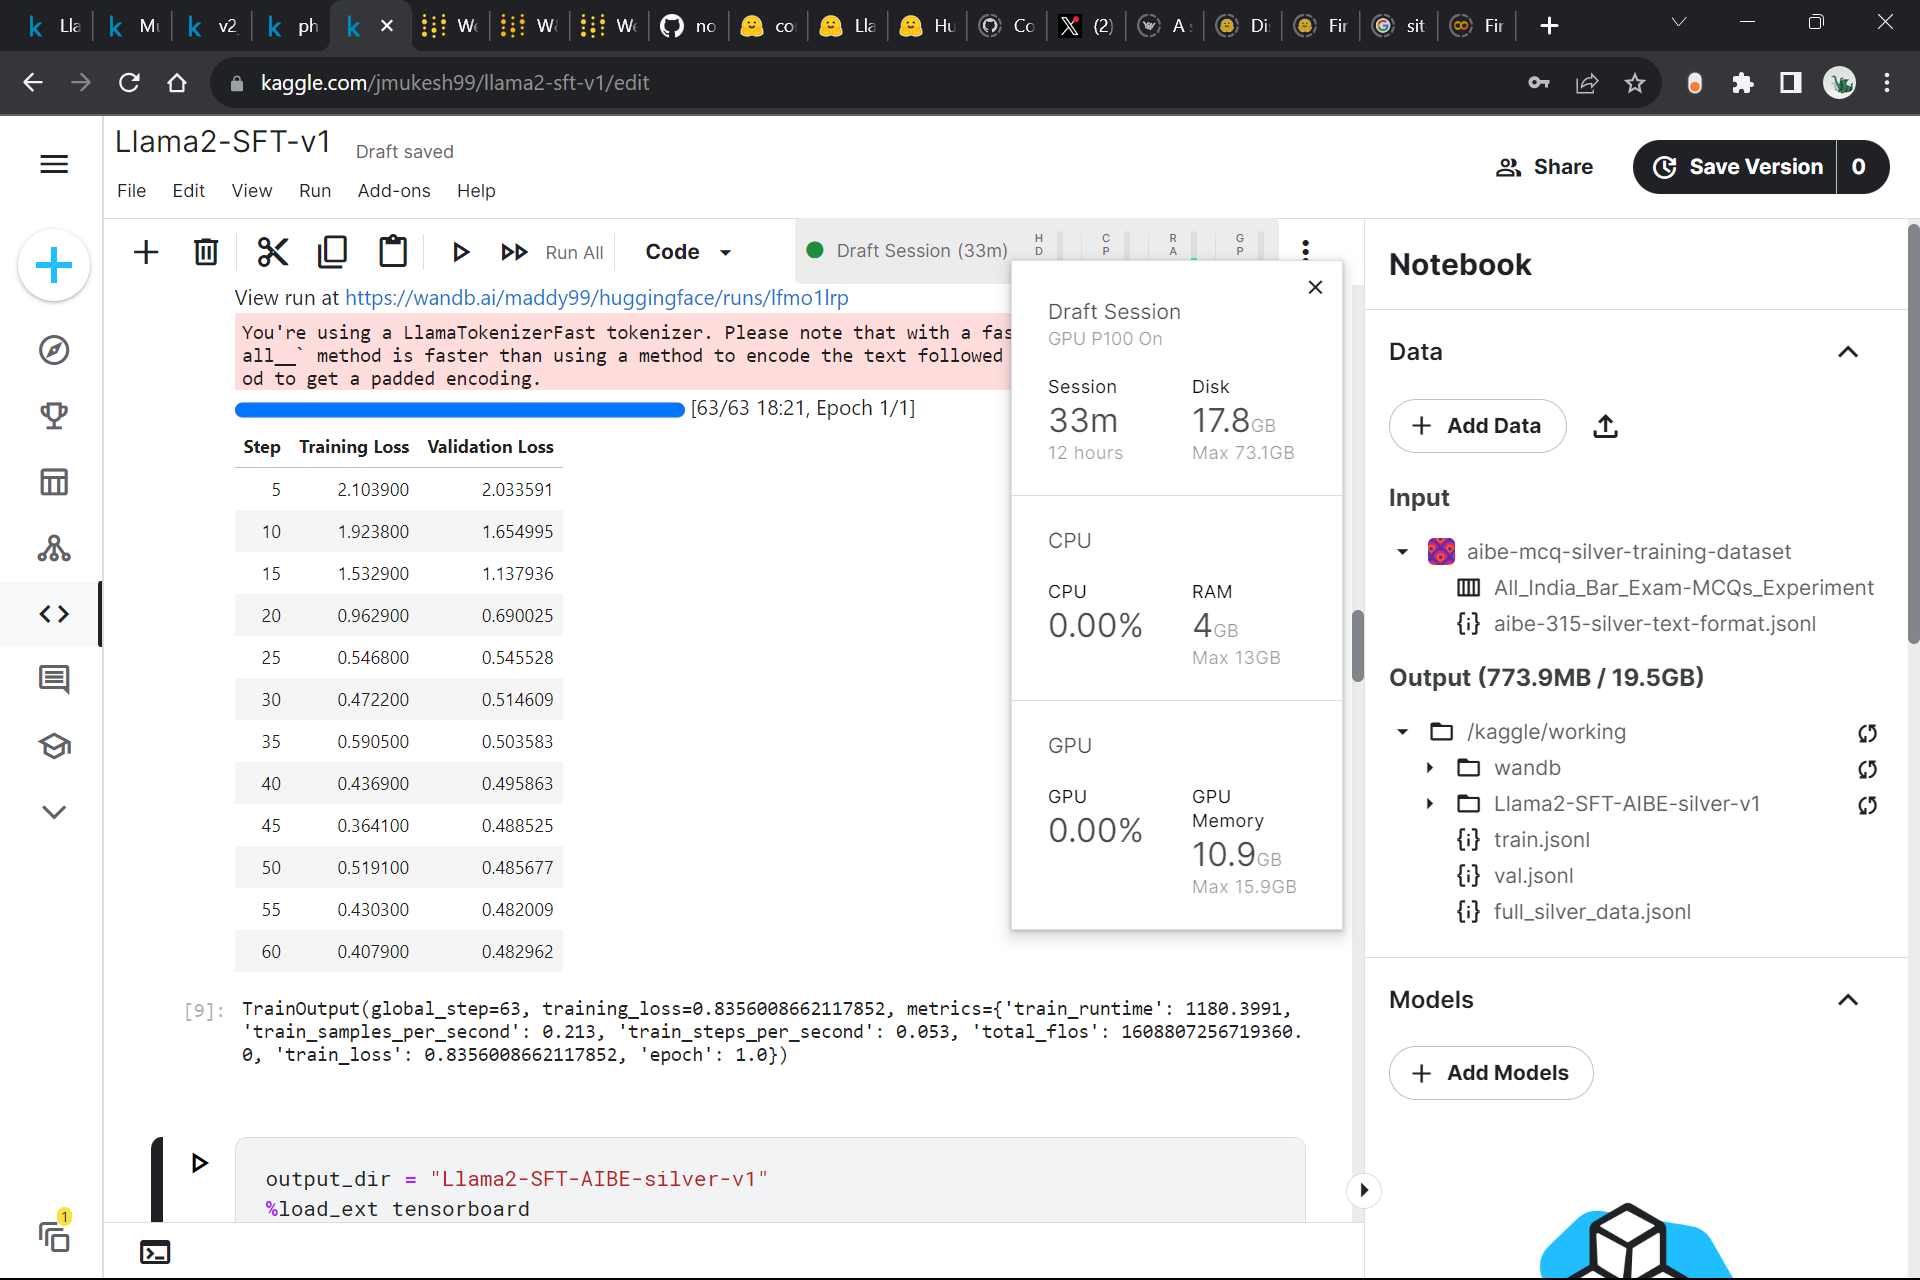

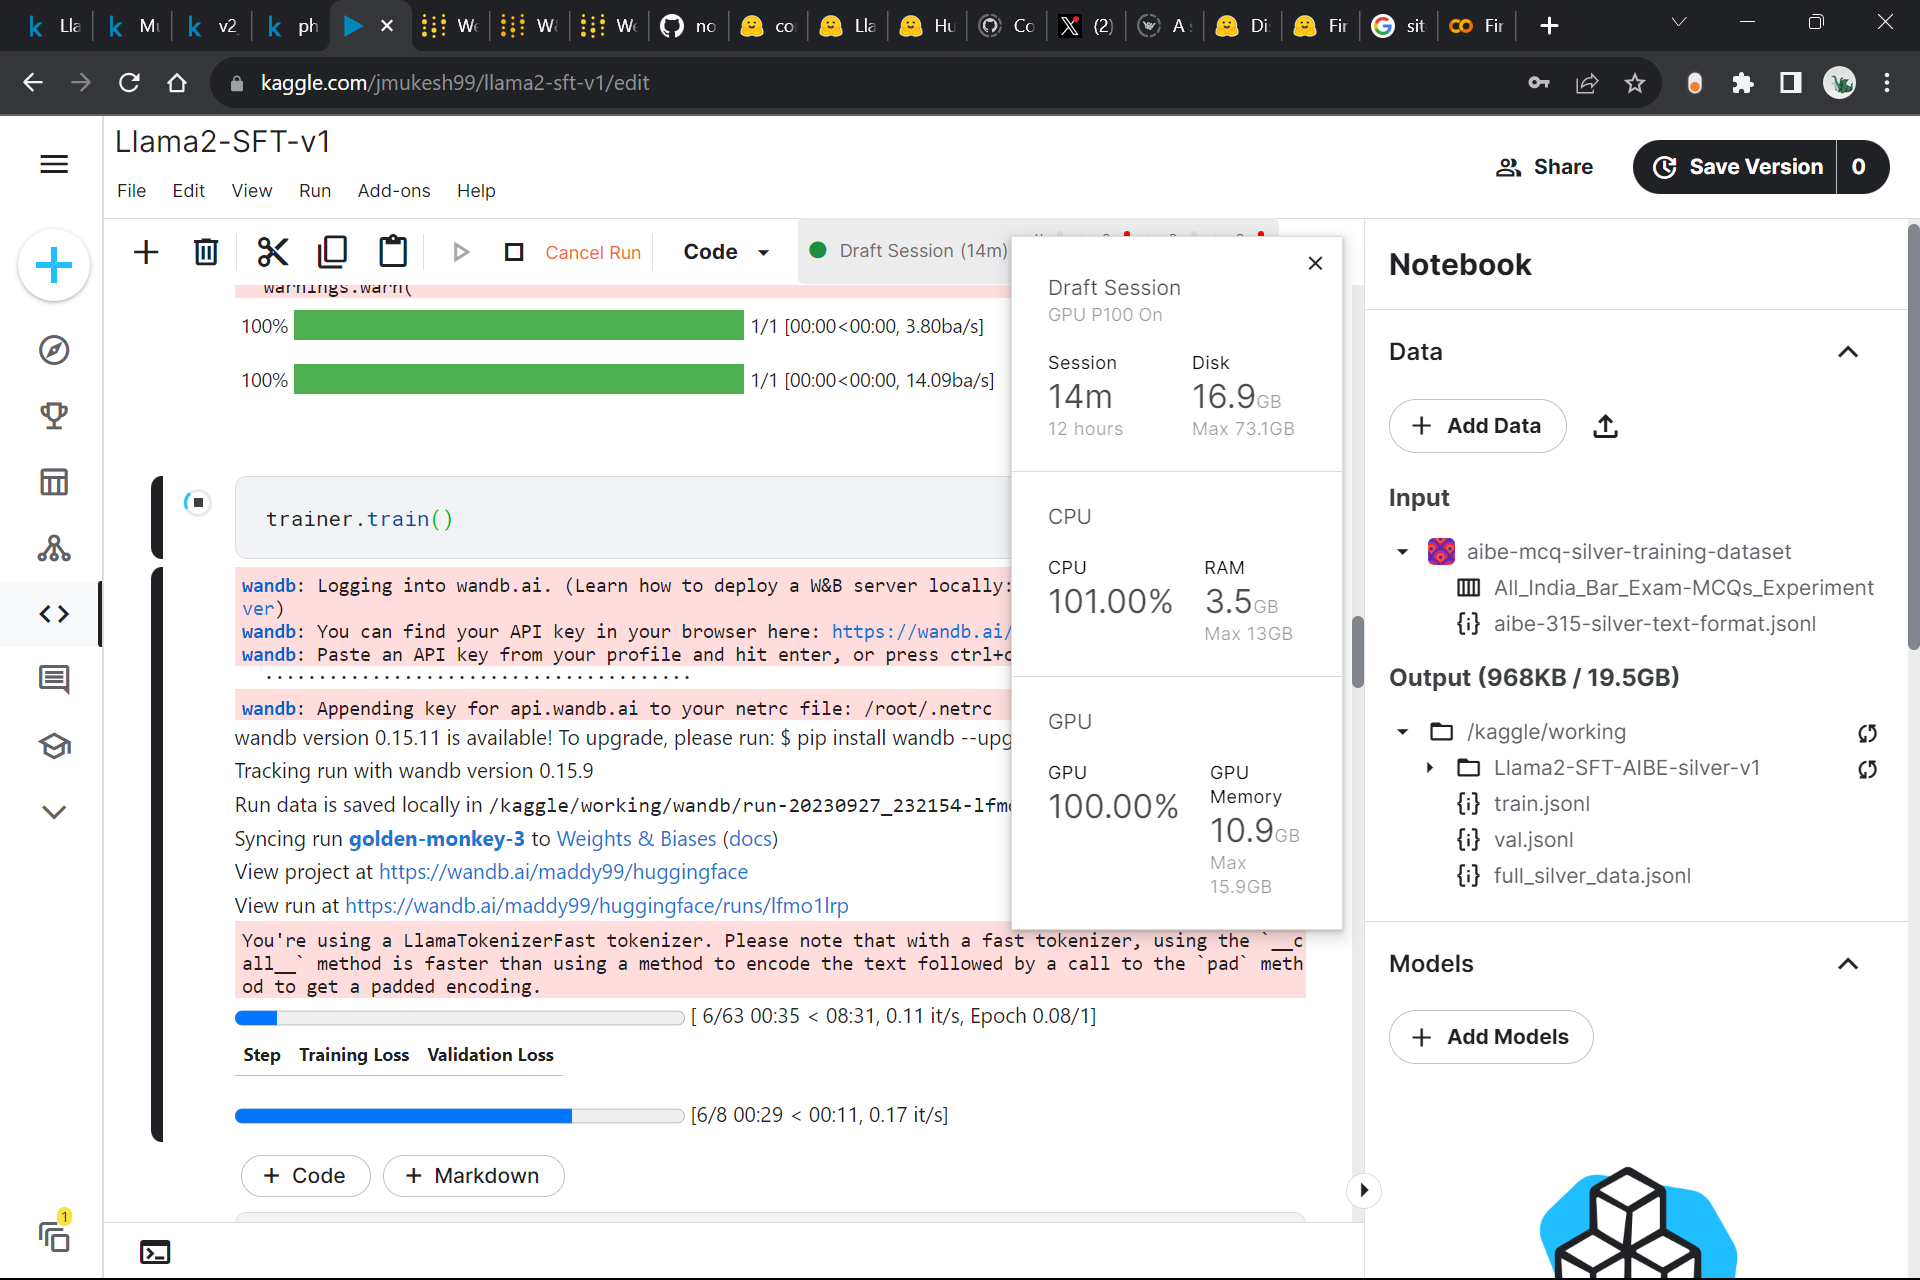

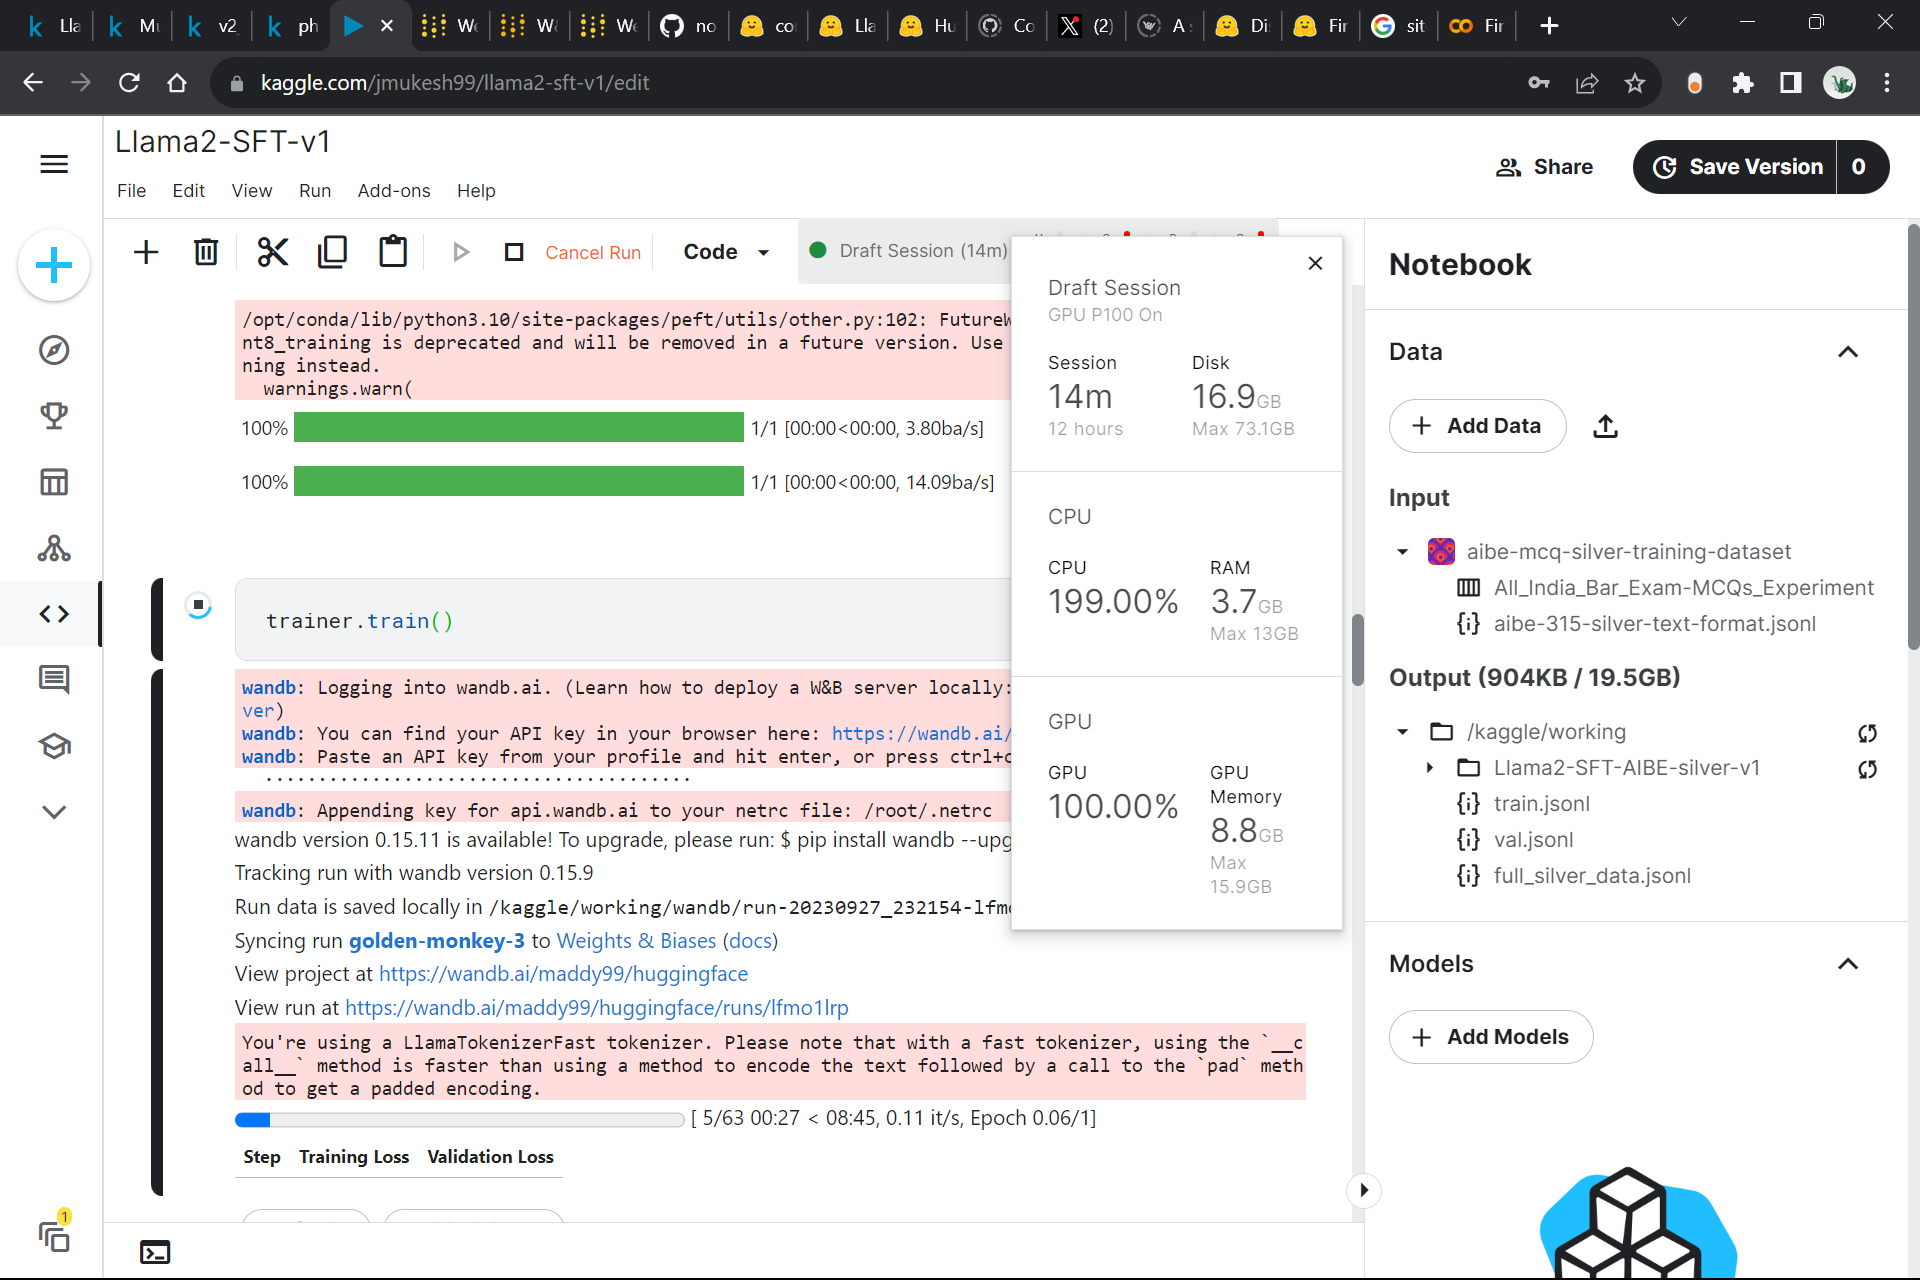